# U2L5.2


## Validating regression models for prediction
Statistical tests are useful for making sure a model is a good fit to the test data, and that all the features are useful to the model. However, to make sure a model has good predictive validity for new data, it is necessary to assess the performance of the model on new datasets.

The procedure is the same as what you learned in the Naive Bayes lesson – the holdout method and cross-validation method are both available. You've already had experience writing code to run these kinds of validation models for Naive Bayes: now you can try it again with linear regression. In this case, your goal is to achieve a model with a consistent R2 and only statistically significant parameters across multiple samples.

In [305]:
import pandas as pd
from matplotlib import pyplot as plt
import numpy as np
from sklearn import linear_model

# Display preferences.
%matplotlib inline
pd.options.display.float_format = '{:.3f}'.format

# Suppress annoying harmless error.

import warnings
warnings.filterwarnings(action="ignore", module="scipy", message="^internal gelsd")

In [306]:
from matplotlib.mlab import PCA as mlabPCA
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA 

In [307]:
link = 'https://raw.githubusercontent.com/Thinkful-Ed/data-201-resources/master/New_York_offenses/NEW_YORK-Offenses_Known_to_Law_Enforcement_by_City_2013%20-%2013tbl8ny.csv'

indices_to_skip = np.array([0,1,2,353,354,355])

df = pd.read_csv(link,skiprows=indices_to_skip , header=1)

df.tail()


,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
343,Woodbury Town,"10,685",3,0,nan,0,2,1,541,9,529,3,nan
344,Woodridge Village,829,7,0,nan,0,0,7,17,8,9,0,0.000
345,Woodstock Town,"5,931",2,0,nan,0,0,2,58,13,45,0,nan
346,Yonkers,"199,134","1,036",6,nan,25,390,615,"2,368",470,"1,662",236,10.000
347,Yorktown Town,"36,643",15,0,nan,0,2,13,334,45,287,2,nan


In [308]:
indices_to_skip = np.array([0,1,2,374,375,376,377,378,379,380])

df2014 = pd.read_excel('Table_8_Offenses_Known_to_Law_Enforcement_by_New_York_by_City_2014.xls'
                       ,skiprows=indices_to_skip , header=1)


In [237]:
df2014.sort_values(by='Population',ascending=False).head()

,City,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
227,New York4,8473938,50564,333,2190.000,nan,16581,31460,135747.000,15916,112107.000,7724,nan
38,Buffalo4,258419,3174,60,174.000,nan,1277,1663,12449.000,3119,8362.000,968,nan
283,Rochester4,210347,1765,27,190.000,nan,698,850,8856.000,2125,6058.000,673,135.000
366,Yonkers4,200624,974,3,33.000,nan,358,580,2009.000,414,1395.000,200,15.000
326,Syracuse4,144534,1164,20,70.000,nan,406,668,5755.000,1404,3986.000,365,57.000


In [238]:
df.shape

(348, 13)

In [239]:
df.dtypes

City                                       object
Population                                 object
Violent\ncrime                             object
Murder and\nnonnegligent\nmanslaughter      int64
Rape\n(revised\ndefinition)1              float64
Rape\n(legacy\ndefinition)2                object
Robbery                                    object
Aggravated\nassault                        object
Property\ncrime                            object
Burglary                                   object
Larceny-\ntheft                            object
Motor\nvehicle\ntheft                      object
Arson3                                    float64
dtype: object

In [240]:
# Not working:
new_cols = ['Murder','Rubberry']
def insert_cols(df):
    for i in range(len(new_cols)):
        #df[new_cols[i]]==np.nan
        return new_cols[i]
    
insert_cols(df)

'Murder'

### Replace ',' before converting to numeric:

In [309]:
cols = df.columns.drop(['City','Murder and\nnonnegligent\nmanslaughter','Rape\n(revised\ndefinition)1','Arson3'])

# Replace ',' before converting to numeric:
df[cols]=df[cols].replace(',*','',regex=True)

# Convert to numeric
df[cols] = df[cols].apply(pd.to_numeric, errors='coerce')

In [310]:
cols = df2014.columns.drop(['City','Murder and\nnonnegligent\nmanslaughter','Rape\n(revised\ndefinition)1','Arson3'])

# Replace ',' before converting to numeric:
df2014[cols]=df2014[cols].replace(',*','',regex=True)

# Convert to numeric
df2014[cols] = df2014[cols].apply(pd.to_numeric, errors='coerce')

In [243]:
df.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,348.000,348.000,348.000,0.000,348.000,348.000,348.000,348.000,348.000,348.000,348.000,187.000
mean,40037.632,201.595,1.566,nan,5.865,72.902,121.261,792.606,119.684,637.017,35.905,1.872
std,450037.368,2815.269,18.304,nan,60.425,1031.033,1706.132,7659.725,924.949,6346.054,403.424,10.693
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,3003.000,2.000,0.000,nan,0.000,0.000,1.000,40.500,6.000,31.000,0.000,0.000
50%,7233.500,6.000,0.000,nan,0.000,1.000,4.000,112.500,17.500,94.000,2.000,0.000
75%,18427.500,22.000,0.000,nan,2.000,5.000,14.000,341.000,51.250,287.250,7.000,1.000
max,8396126.000,52384.000,335.000,nan,1112.000,19170.000,31767.000,141971.000,16606.000,117931.000,7434.000,132.000


In [244]:
df2014.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,369.000,369.000,369.000,227.000,142.000,369.000,369.000,368.000,369.000,368.000,369.000,365.000
mean,37814.824,183.691,1.453,15.555,0.007,60.661,112.005,698.361,100.900,562.791,34.317,1.425
std,441159.058,2638.842,17.694,146.261,0.084,866.481,1640.515,7123.614,855.103,5869.850,406.957,7.995
min,79.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2631.000,1.000,0.000,0.000,0.000,0.000,0.000,25.000,4.000,20.000,0.000,0.000
50%,6581.000,5.000,0.000,1.000,0.000,1.000,3.000,76.000,12.000,60.500,2.000,0.000
75%,15408.000,18.000,0.000,4.000,0.000,4.000,12.000,271.500,39.000,228.500,6.000,1.000
max,8473938.000,50564.000,333.000,2190.000,1.000,16581.000,31460.000,135747.000,15916.000,112107.000,7724.000,135.000


### >>> std in `Population` is huge, this is an outlier that kills the analysis!

Drop values in "Population" that are outliers (more than 3 stdev from the mean):

In [311]:
q = df["Population"].quantile(0.99)
df2=df[df["Population"] < q].sort_values('Population', ascending=False)

In [312]:
q = df2014["Population"].quantile(0.99)
df22=df2014[df2014["Population"] < q].sort_values('Population', ascending=False)

In [313]:
df2.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,344.000,344.000,344.000,0.000,344.000,344.000,344.000,344.000,344.000,344.000,344.000,185.000
mean,14152.573,33.078,0.334,nan,1.939,10.378,20.427,316.703,53.863,253.366,9.474,1.124
std,18876.821,105.876,1.560,nan,5.662,36.304,64.049,602.881,134.721,454.847,28.851,4.758
min,526.000,0.000,0.000,nan,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2983.250,2.000,0.000,nan,0.000,0.000,1.000,39.000,6.000,31.000,0.000,0.000
50%,7106.000,6.000,0.000,nan,0.000,1.000,4.000,111.500,17.000,93.500,2.000,0.000
75%,17889.250,21.000,0.000,nan,2.000,5.000,13.250,334.750,50.000,275.500,7.000,1.000
max,143834.000,1192.000,21.000,nan,75.000,400.000,696.000,6473.000,1781.000,4298.000,394.000,57.000


In [248]:
df22.describe()

,Population,Violent crime,Murder and nonnegligent manslaughter,Rape (revised definition)1,Rape (legacy definition)2,Robbery,Aggravated assault,Property crime,Burglary,Larceny- theft,Motor vehicle theft,Arson3
count,365.000,365.000,365.000,223.000,142.000,365.000,365.000,364.000,365.000,364.000,365.000,363.000
mean,13179.019,30.973,0.310,4.233,0.007,9.507,18.567,269.055,42.899,217.541,8.488,1.019
std,18605.365,102.287,1.414,9.955,0.084,34.751,60.711,555.891,110.357,432.246,26.932,3.783
min,79.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000
25%,2620.000,1.000,0.000,0.000,0.000,0.000,0.000,24.750,4.000,20.000,0.000,0.000
50%,6467.000,5.000,0.000,1.000,0.000,1.000,3.000,75.000,12.000,59.000,2.000,0.000
75%,15216.000,17.000,0.000,3.000,0.000,4.000,11.000,264.500,38.000,212.750,6.000,1.000
max,144534.000,1164.000,20.000,70.000,1.000,406.000,668.000,5755.000,1404.000,3986.000,365.000,57.000


In [249]:
df2['Robbery'].value_counts().head(10)

0     139
1      56
2      25
3      23
4      14
5      10
16      7
6       6
13      5
11      5
Name: Robbery, dtype: int64

In [250]:
df22['Robbery'].value_counts().head(10)

0     173
1      49
2      24
4      21
3      19
7       8
8       6
12      5
6       5
5       4
Name: Robbery, dtype: int64

### Create a new column from `Robbery` that has binary data based on condition:

In [314]:
df2['Robbery2'] = np.where(df2['Robbery']>5, 1, 0)

# Check to make sure it worked.
print(df2['Robbery'].groupby(df2['Robbery2']).describe())

           count   mean    std   min    25%    50%    75%     max
Robbery2                                                         
0        267.000  1.052  1.426 0.000  0.000  0.000  2.000   5.000
1         77.000 42.714 67.647 6.000 10.000 16.000 31.000 400.000


In [315]:
df22['Robbery2'] = np.where(df22['Robbery']>5, 1, 0)

# Check to make sure it worked.
print(df22['Robbery'].groupby(df22['Robbery2']).describe())

           count   mean    std   min   25%    50%    75%     max
Robbery2                                                        
0        290.000  0.890  1.345 0.000 0.000  0.000  1.000   5.000
1         75.000 42.827 67.209 6.000 9.000 17.000 37.500 406.000


### Use 'Larceny-\ntheft' column as a new member in the equation for predicting Property Crimes!

In [316]:
df2.loc[df['Murder and\nnonnegligent\nmanslaughter']>0,'Murder']=1
df2.loc[df['Murder and\nnonnegligent\nmanslaughter']==0,'Murder']=0

In [317]:
df22.loc[df2014['Murder and\nnonnegligent\nmanslaughter']>0,'Murder']=1
df22.loc[df2014['Murder and\nnonnegligent\nmanslaughter']==0,'Murder']=0

In [255]:
df2.columns

Index(['City', 'Population', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
       'Robbery', 'Aggravated\nassault', 'Property\ncrime', 'Burglary',
       'Larceny-\ntheft', 'Motor\nvehicle\ntheft', 'Arson3', 'Robbery2',
       'Murder'],
      dtype='object')

In [318]:
df2=df2.drop(['City', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
        'Aggravated\nassault', 'Burglary', 'Robbery',
       'Motor\nvehicle\ntheft', 'Arson3'],axis=1)

In [319]:
df22=df22.drop(['City', 'Violent\ncrime',
       'Murder and\nnonnegligent\nmanslaughter',
       'Rape\n(revised\ndefinition)1', 'Rape\n(legacy\ndefinition)2',
        'Aggravated\nassault', 'Burglary', 'Robbery',
       'Motor\nvehicle\ntheft', 'Arson3'],axis=1)

In [320]:
df2.dtypes

Population           int64
Property\ncrime      int64
Larceny-\ntheft      int64
Robbery2             int32
Murder             float64
dtype: object

In [321]:
df22.dtypes

Population           int64
Property\ncrime    float64
Larceny-\ntheft    float64
Robbery2             int32
Murder             float64
dtype: object

-------------
$$ Property crime = \alpha + Population +  Murder + Robbery + Larceny$$

In [322]:
# Create a new df to hold only these variable:

prop_crime = df2[['Property\ncrime','Population','Murder','Robbery2','Larceny-\ntheft']]
prop_crime.head()

,Property crime,Population,Murder,Robbery2,Larceny- theft
310,6473,143834,1.000,1,4298
7,2118,118296,1.000,1,1882
3,4090,97956,1.000,1,3243
126,2303,96667,0.000,1,1925
267,567,87204,1.000,1,466


In [323]:
# Create a new df to hold only these variable:

prop_crime22 = df22[['Property\ncrime','Population','Murder','Robbery2','Larceny-\ntheft']]
prop_crime22.head()

,Property crime,Population,Murder,Robbery2,Larceny- theft
326,5755.000,144534,1.000,1,3986.000
9,2066.000,118860,1.000,1,1846.000
4,3888.000,98595,1.000,1,3083.000
130,2430.000,97144,1.000,1,2073.000
279,643.000,88881,0.000,1,536.000


In [262]:
prop_crime.describe()

,Property crime,Population,Murder,Robbery2,Larceny- theft
count,344.000,344.000,344.000,344.000,344.000
mean,316.703,14152.573,0.131,0.224,253.366
std,602.881,18876.821,0.338,0.417,454.847
min,0.000,526.000,0.000,0.000,0.000
25%,39.000,2983.250,0.000,0.000,31.000
50%,111.500,7106.000,0.000,0.000,93.500
75%,334.750,17889.250,0.000,0.000,275.500
max,6473.000,143834.000,1.000,1.000,4298.000


### There are a few big outliers !
We need feature transformation: drop outliers, apply log, cube etc

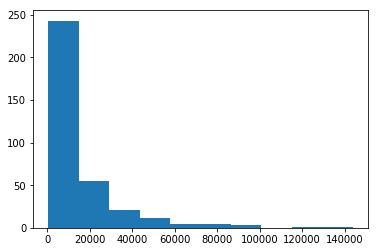

In [324]:
plt.hist(prop_crime['Population'],bins=10)
plt.show()

In [264]:
# Who are the biggest towns ?
prop_crime.sort_values('Population', ascending=False).head(5)

,Property crime,Population,Murder,Robbery2,Larceny- theft
310,6473,143834,1.000,1,4298
7,2118,118296,1.000,1,1882
3,4090,97956,1.000,1,3243
126,2303,96667,0.000,1,1925
267,567,87204,1.000,1,466


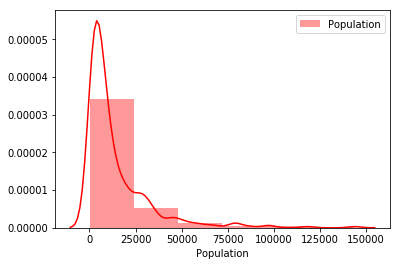

In [265]:
import seaborn as sns

sns.distplot( prop_crime["Population"] , color="red", label="Population",bins=6)
plt.legend()
plt.show()

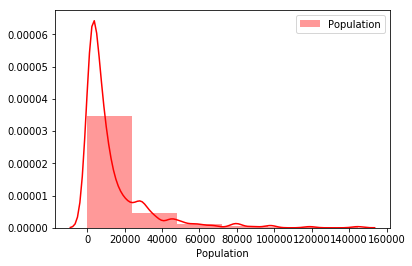

In [325]:
import seaborn as sns

sns.distplot( prop_crime22["Population"] , color="red", label="Population",bins=6)
plt.legend()
plt.show()

###  a continuous and a categorical pair:
* boxplot

### Plot the 3 numerical features with boxplots for each 'Murder' situation.

In [326]:
# Restructure the data so we can use FacetGrid rather than making a boxplot
# for each variable separately.

df_murder_cols = prop_crime.columns.drop(['Robbery2'])
df_murder = prop_crime[df_murder_cols]
#df_murder.head(50)

In [327]:
# Restructure the data so we can use FacetGrid rather than making a boxplot
# for each variable separately.

df_murder_cols22 = prop_crime22.columns.drop(['Robbery2'])
df_murder22 = prop_crime22[df_murder_cols22]
#df_murder.head(50)

In [328]:
df_murder = pd.melt(df_murder, id_vars=['Murder'])
#df_murder
#df_murder.variable.value_counts()

C:\Anaconda3\lib\site-packages\seaborn\axisgrid.py:703: UserWarning: Using the boxplot function without specifying `order` is likely to produce an incorrect plot.
  warnings.warn(warning)


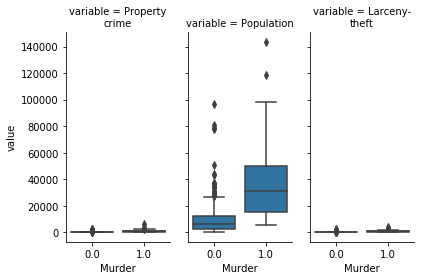

In [329]:
g = sns.FacetGrid(df_murder, col="variable", size=4, aspect=.5)
g = g.map(sns.boxplot, "Murder", "value")
plt.show()

* Because the three columns haven't been normalized, this plot is not yet relevant.

We'll do this step soon.

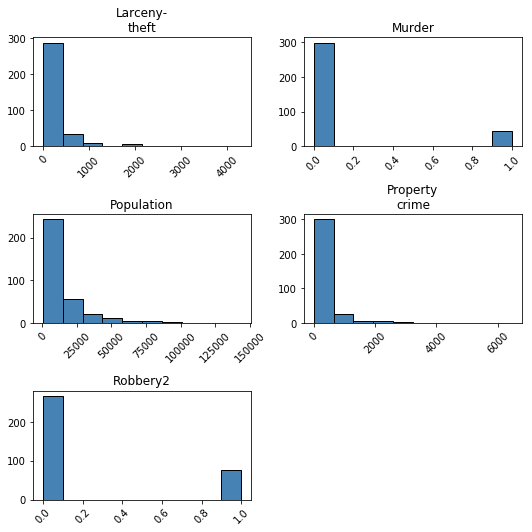

In [330]:
# Plot histograms to see what kind of distribution there is in each column:

fig = prop_crime.hist(bins=10,
                 color='steelblue',
                 edgecolor='black', linewidth=1.0,
                 xlabelsize=10, ylabelsize=10,
                 xrot=45, yrot=0,
                 figsize=(5,5),
                 grid=False)

plt.tight_layout(rect=(0, 0, 1.5, 1.5))   

* For numerical columns: they are skewed to the right.

Categorigal columns don't have any interpretation.

### Create the default pairplot for numerical columns to better see how data is groupping:

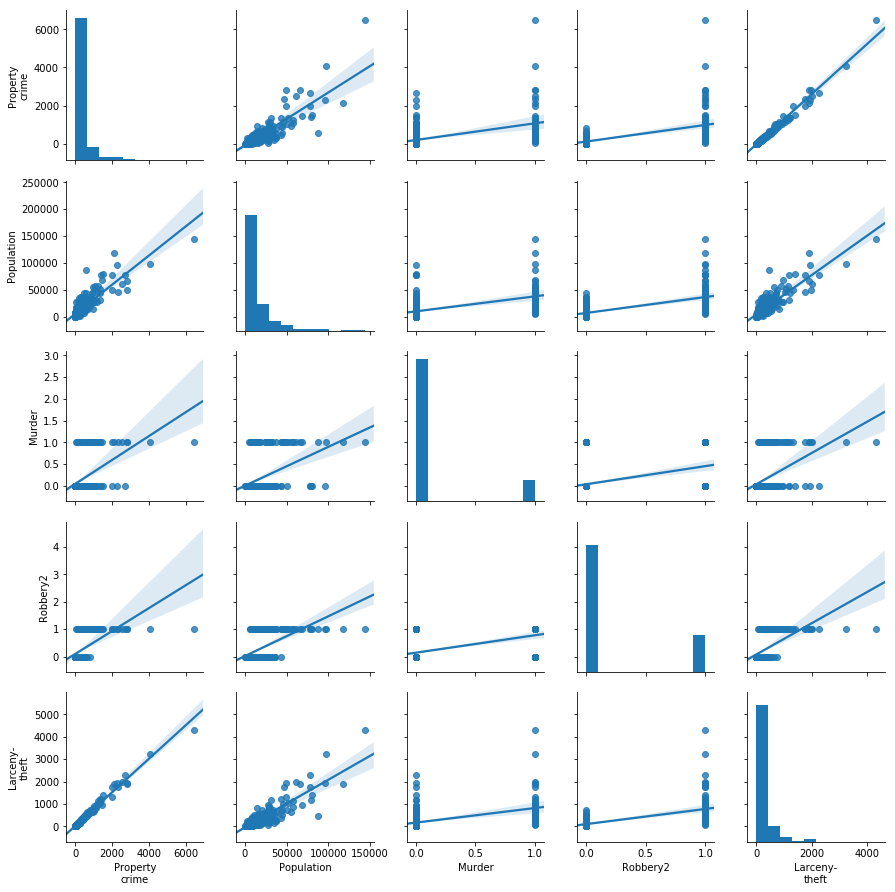

In [331]:
g=sns.pairplot(prop_crime.fillna(0) , diag_kind='hist' , kind='reg' )
plt.show()

### The histograms show no normal distribution. We should apply <u>feature transformations</u> on both numerical and categorical columns!

* The two categorical columns, Robbery and Murder, can be transformed into numeric representations with `getdummies`

In [332]:
# Making dummies.
# Also creating a data frame to hold our features.
features1 = pd.get_dummies(prop_crime['Murder'])
features1.columns=['Murder_False','Murder_True']

features2 = pd.get_dummies(prop_crime['Robbery2'])
features2.columns=['Robbery_False','Robbery_True']
features = pd.concat((features1 , features2),axis=1)
features.head()

,Murder_False,Murder_True,Robbery_False,Robbery_True
310,0,1,0,1
7,0,1,0,1
3,0,1,0,1
126,1,0,0,1
267,0,1,0,1


In [333]:
# Making dummies.
# Also creating a data frame to hold our features.
features12 = pd.get_dummies(prop_crime22['Murder'])
features12.columns=['Murder_False','Murder_True']

features22 = pd.get_dummies(prop_crime22['Robbery2'])
features22.columns=['Robbery_False','Robbery_True']
features2014 = pd.concat((features12 , features22),axis=1)
features2014.head()

,Murder_False,Murder_True,Robbery_False,Robbery_True
326,0,1,0,1
9,0,1,0,1
4,0,1,0,1
130,0,1,0,1
279,1,0,0,1


In [334]:
prop_crime2 =  pd.concat((prop_crime , features),axis=1)
prop_crime2 = prop_crime2.drop(['Murder','Robbery2'],1)

In [335]:
prop_crime2014 =  pd.concat((prop_crime22 , features2014),axis=1)
prop_crime2014 = prop_crime2014.drop(['Murder','Robbery2'],1)

### Logarithm: 
Log of a variable is a common transformation method used to change the shape of distribution of the variable on a distribution plot. It is generally used for reducing right skewness of variables. Though, It can’t be applied to <b><u>zero</u></b> or negative values as well.

### From the three numerical columns, only 'Property crime' could have zero values, b/c the population can't be zero!

In [336]:

print(prop_crime2[prop_crime2['Property\ncrime']<=0])


     Property\ncrime  Population  Larceny-\ntheft  Murder_False  Murder_True  \
186                0        1688                0             1            0   
208                0        1622                0             1            0   
295                0        1437                0             1            0   
256                0        1274                0             1            0   
287                0         872                0             1            0   
319                0         615                0             1            0   

     Robbery_False  Robbery_True  
186              1             0  
208              1             0  
295              1             0  
256              1             0  
287              1             0  
319              1             0  


In [337]:

print(prop_crime2014[prop_crime2014['Property\ncrime']<=0])


     Property\ncrime  Population  Larceny-\ntheft  Murder_False  Murder_True  \
10             0.000        2250            0.000             1            0   
308            0.000        1429            0.000             1            0   
169            0.000        1178            0.000             1            0   
238            0.000        1084            0.000             1            0   
301            0.000         857            0.000             1            0   
335            0.000         612            0.000             1            0   

     Robbery_False  Robbery_True  
10               1             0  
308              1             0  
169              1             0  
238              1             0  
301              1             0  
335              1             0  


### >> we can drop these ZERO lines b/c population is very small and probably won't influence the analysis too much!

In [338]:
prop_crime2.is_copy = False # to deal with 'SettingWithCopyWarning'.
prop_crime2.drop(prop_crime2[prop_crime2['Property\ncrime']<=0].index , inplace=True)

In [339]:
prop_crime2014.is_copy = False # to deal with 'SettingWithCopyWarning'.
prop_crime2014.drop(prop_crime2014[prop_crime2014['Property\ncrime']<=0].index , inplace=True)

In [281]:
prop_crime2.columns

Index(['Property\ncrime', 'Population', 'Larceny-\ntheft', 'Murder_False',
       'Murder_True', 'Robbery_False', 'Robbery_True'],
      dtype='object')

In [340]:
prop_crime_log = prop_crime2[['Property\ncrime','Population','Larceny-\ntheft']].apply(np.log)
prop_crime_log.sort_values(by='Larceny-\ntheft').head(5)

,Property crime,Population,Larceny- theft
128,0.000,7.348,-inf
227,0.000,7.000,0.000
95,0.000,8.691,0.000
12,0.693,6.489,0.693
44,0.693,6.636,0.693


In [341]:
prop_crime_log2014 = prop_crime2014[['Property\ncrime','Population','Larceny-\ntheft']].apply(np.log)
prop_crime_log2014.sort_values(by='Larceny-\ntheft').head(5)

,Property crime,Population,Larceny- theft
323,0.000,7.917,-inf
8,0.693,7.452,-inf
197,0.000,7.421,-inf
291,0.000,7.320,-inf
121,1.099,7.557,0.000


In [342]:
prop_crime_log['Larceny-\ntheft'].replace(-np.inf, 0, inplace=True)

In [343]:
prop_crime_log2014['Larceny-\ntheft'].replace(-np.inf, 0, inplace=True)

In [344]:
prop_crime_log2014=prop_crime_log2014.fillna(0)

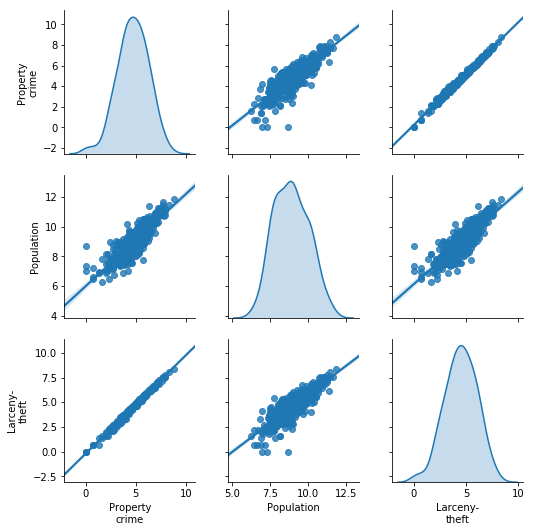

In [345]:
g=sns.pairplot(prop_crime_log, diag_kind='kde' , kind='reg'
               #, plot_kws=dict(edgecolor="k", linewidth=0.5)
               , diag_kws=dict(shade=True)
              )
plt.show()

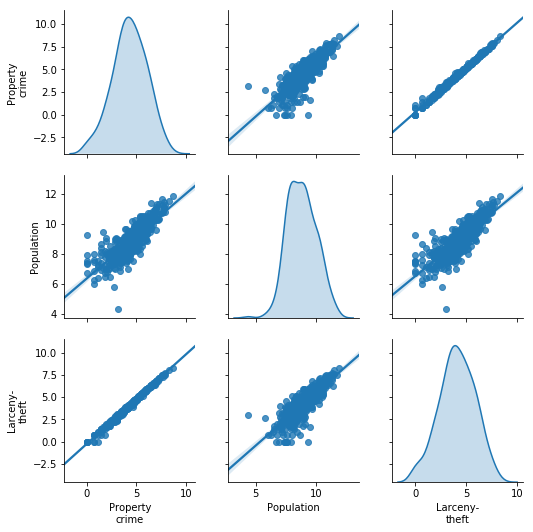

In [346]:
g=sns.pairplot(prop_crime_log2014, diag_kind='kde' , kind='reg'
               #, plot_kws=dict(edgecolor="k", linewidth=0.5)
               , diag_kws=dict(shade=True)
              )
plt.show()

### Now the histograms look more <u>normal</u> and the scatter plots are more linearly oriented!

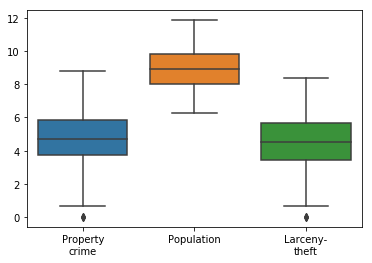

In [347]:
sns.boxplot( data = prop_crime_log )
plt.show()

###  StandardScaler or MinMaxScaler.

Also these scalers are good for normal data.

When we want to change the scale of a variable or standardize the values of a variable for better understanding. While this transformation is a must if you have data in different scales, this transformation <u>does not change the shape</u> of the variable distribution

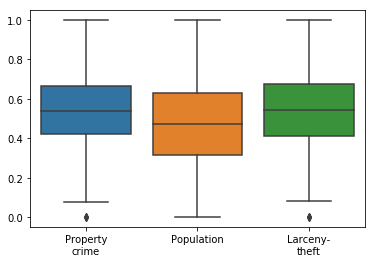

In [348]:
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,quantile_transform
scaler = MinMaxScaler()

b_fit_scaled = scaler.fit_transform(prop_crime_log)

index = ['Row'+str(i) for i in range(1, len(b_fit_scaled)+1)]
df_fit_scaled = pd.DataFrame(b_fit_scaled, index=prop_crime_log.index , columns = prop_crime_log.columns )

sns.boxplot( data = df_fit_scaled )
plt.show()

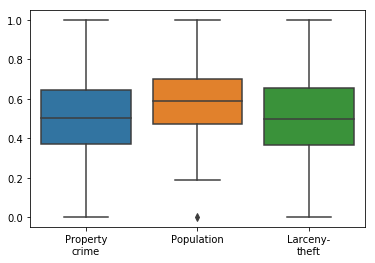

In [349]:
import pandas as pd
from sklearn.preprocessing import RobustScaler,StandardScaler,MinMaxScaler,quantile_transform
scaler = MinMaxScaler()

b_fit_scaled2014 = scaler.fit_transform(prop_crime_log2014)

index = ['Row'+str(i) for i in range(1, len(b_fit_scaled2014)+1)]
df_fit_scaled2014 = pd.DataFrame(b_fit_scaled2014, index=prop_crime_log2014.index 
                                , columns = prop_crime_log2014.columns )

sns.boxplot( data = df_fit_scaled2014 )
plt.show()


### Already have dropped values in "Population" that are outliers (more than 3 stdev from the mean)


### Create a correlation matrix between continuous variables:

                 Property\ncrime  Population  Larceny-\ntheft  Murder_False  \
Property\ncrime            1.000       0.863            0.992        -0.488   
Population                 0.863       1.000            0.881        -0.496   
Larceny-\ntheft            0.992       0.881            1.000        -0.483   
Murder_False              -0.488      -0.496           -0.483         1.000   
Murder_True                0.488       0.496            0.483        -1.000   
Robbery_False             -0.601      -0.652           -0.619         0.514   
Robbery_True               0.601       0.652            0.619        -0.514   

                 Murder_True  Robbery_False  Robbery_True  
Property\ncrime        0.488         -0.601         0.601  
Population             0.496         -0.652         0.652  
Larceny-\ntheft        0.483         -0.619         0.619  
Murder_False          -1.000          0.514        -0.514  
Murder_True            1.000         -0.514         0.514  
Robbery

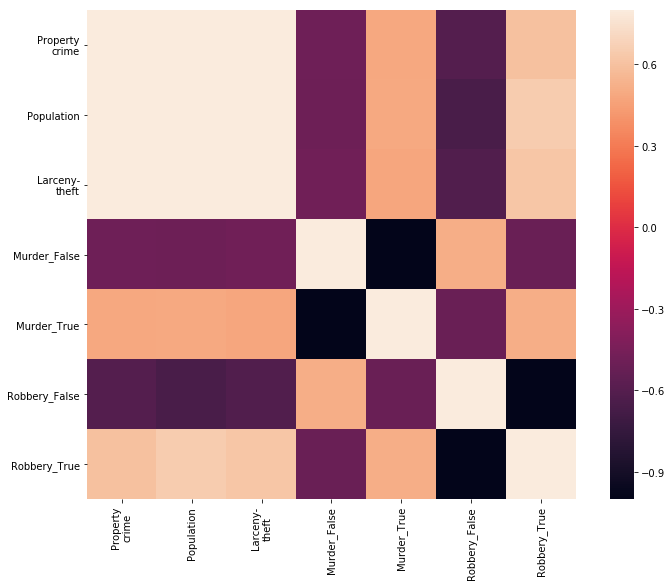

In [350]:
corrmat = prop_crime2.corr()
print(corrmat)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax=.8, square=True)
plt.show()

                 Property\ncrime  Population  Larceny-\ntheft  Murder_False  \
Property\ncrime            1.000       0.865            0.993        -0.576   
Population                 0.865       1.000            0.877        -0.574   
Larceny-\ntheft            0.993       0.877            1.000        -0.574   
Murder_False              -0.576      -0.574           -0.574         1.000   
Murder_True                0.576       0.574            0.574        -1.000   
Robbery_False             -0.620      -0.668           -0.634         0.552   
Robbery_True               0.620       0.668            0.634        -0.552   

                 Murder_True  Robbery_False  Robbery_True  
Property\ncrime        0.576         -0.620         0.620  
Population             0.574         -0.668         0.668  
Larceny-\ntheft        0.574         -0.634         0.634  
Murder_False          -1.000          0.552        -0.552  
Murder_True            1.000         -0.552         0.552  
Robbery

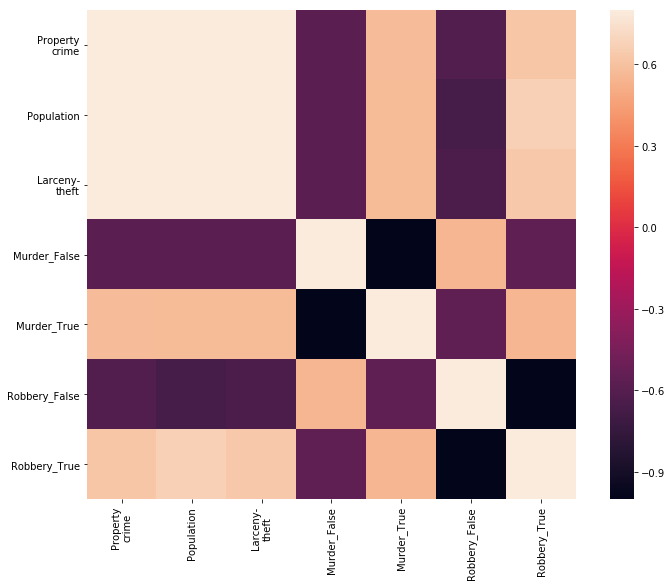

In [351]:
corrmat2014 = prop_crime2014.corr()
print(corrmat2014)

# Set up the matplotlib figure.
f, ax = plt.subplots(figsize=(12, 9))

# Draw the heatmap using seaborn
sns.heatmap(corrmat2014, vmax=.8, square=True)
plt.show()

* It looks like there is a lot of correlation. Population and population_squared are redundant.

In [376]:
X_cols = prop_crime2.columns.drop(['Property\ncrime' ])
X_cols

Index(['Population', 'Larceny-\ntheft', 'Murder_False', 'Murder_True',
       'Robbery_False', 'Robbery_True'],
      dtype='object')

In [353]:
X_cols2014 = prop_crime2014.columns.drop(['Property\ncrime' ])
X_cols2014

Index(['Population', 'Larceny-\ntheft', 'Murder_False', 'Murder_True',
       'Robbery_False', 'Robbery_True'],
      dtype='object')

In [354]:
# Instantiate and fit our model.
regr = linear_model.LinearRegression()
Y = prop_crime2['Property\ncrime'].values.reshape(-1, 1)
X = prop_crime2[X_cols]
regr.fit(X, Y)

# Inspect the results.
print('\nCoefficients: \n', regr.coef_)
print('\nIntercept: \n', regr.intercept_)
print('\nR-squared:')
print(regr.score(X, Y))


Coefficients: 
 [[-1.43956980e-03  1.37080757e+00 -2.04073446e+01  2.04073446e+01
   1.55091182e+01 -1.55091182e+01]]

Intercept: 
 [-3.92244605]

R-squared:
0.9850619370775062


In [355]:
prop_crime2014=prop_crime2014.fillna(0)

Y2014 = prop_crime2014['Property\ncrime'].values.reshape(-1, 1)
X2014 = prop_crime2014[X_cols2014]

In [356]:
# Test your model with different holdout groups.
# https://courses.thinkful.com/data-201v1/assignment/2.3.3

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.2, random_state=20)
print('With 20% Holdout: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))
print('Testing on Sample: ' + str(regr.fit(X, Y).score(X, Y)))

With 20% Holdout: 0.9738825883460259
Testing on Sample: 0.9850619370775062


### Test your model with 2014 FBI data.

In [357]:
# Test your model with 2014 FBI data.
# https://courses.thinkful.com/data-201v1/assignment/2.3.3

from sklearn.model_selection import train_test_split
# Use train_test_split to create the necessary training and test groups
X_train, X_test, y_train, y_test = train_test_split(X, Y, test_size=0.01, random_state=20)
# print('With 20% data: ' + str(regr.fit(X_train, y_train).score(X_test, y_test)))

print('With FBI 2014 data: ' + str(regr.fit(X_train, y_train).score(X2014, Y2014)))


With FBI 2014 data: 0.9858796025368234


### Cross Validation:

In [358]:
from sklearn.model_selection import cross_val_score
cross_val_score(regr, X, Y, cv=10)

array([0.94151309, 0.95638618, 0.92918849, 0.9173834 , 0.92770792,
       0.85282838, 0.94177733, 0.89232535, 0.93941097, 0.5238654 ])

* It seems there is some overfitting in the data due to the disparate value of '0.5238654 '

In [359]:
y_pred = regr.fit(X,Y).predict(X)

### What is Principal Components Analysis (PCA)?
PCA is a complexity-reduction technique that tries to reduce a set of variables down to a smaller set of components that represent most of the information in the variables. At a conceptual level, PCA works by identifying sets of variables that share variance, and creating a component to represent that variance.

### PCA works best for normally-distributed data 
PCA works best for normally-distributed data and assumes the relationships among variables are linear. 

PCA also works best when the variables involved range from weakly correlated to moderately strongly correlated. Correlations of 0, or correlations greater than .7 or .8, create problems. Correlations near 0 mean there is no shared information. 

### Correlations that are too high can result in components that are unstable 
and change a lot in response to very small changes in the data, or components that are made up of variance from only one or two variables. 
* <i>A few very high or very low correlations are fine.</i>

### Eigenvalues
Eigenvalues represent the length of the Eigenvectors – each eigenvector has an eigenvalue. 

>The length of the eigenvector encodes the proportion of total variance explained by a component. 

The total variance is equal to the number of variables in the PCA. Thus, an Eigenvalue of 1 means that the component explains the same amount of variance as one variable. An eigenvalue greater than 1 is desirable, since a component with an eigenvalue of 1 adds no value beyond the information contained in any individual variable, and an eigenvalue of less than 1 is actually less efficient at conveying information than a variable by itself. An eigenvalue of 2 means that the component contains an amount of information equal to that of two variables. Of course, it doesn’t mean that only two variables load on that component.

In [381]:
# Take a subset of the data for PCA and drop missing values because PCA cannot
# handle them. We could also impute, but missingness is quite low so dropping
# missing rows is unlikely to create bias.
df_pca = prop_crime2.drop(['Property\ncrime' ], axis=1)

# Normalize the data so that all variables have a mean of 0 and standard deviation
# of 1.
X_pca = StandardScaler().fit_transform(df_pca)

In [391]:
sklearn_pca = PCA(n_components = len(df_pca.columns) )
Y_sklearn = sklearn_pca.fit_transform(X_pca)

print(
    'The percentage of total variance in the dataset explained by each',
    'component from Sklearn PCA.\n',
    sklearn_pca.explained_variance_ratio_
)

The percentage of total variance in the dataset explained by each component from Sklearn PCA.
 [6.91617747e-01 1.77169836e-01 1.11587436e-01 1.96249810e-02
 9.29091933e-33 1.65347049e-34]


### The first 3 components explain 98%(=69+18+11) of the variation of the initial features!

Below we'll see if both should be kept or not.

In [384]:
# What are the numbers of the eigenvalues?
pca = PCA()
eigenvalues = sklearn_pca.explained_variance_
eigenvalues

array([4.16202015e+00, 1.06617338e+00, 6.71511334e-01, 1.18099292e-01,
       5.59109329e-32, 9.95026159e-34])

Upon visual inspection, the analyst will keep all the components whose eigenvalue falls above the point where the slope of the line changes the most drastically, also called the "elbow":

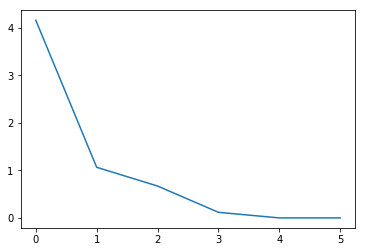

In [385]:
plt.plot(eigenvalues)
plt.show()

* We should keep the first 2 components because they are greater than 1 and both are where the elbow has the slope with the biggest dramatic change. 

In [413]:
principalDf = pd.DataFrame(data = Y_sklearn[:,0:2]
             , columns = ['principal component 1', 'principal component 2'])
principalDf#.head()

,principal component 1,principal component 2
0,9.936,2.260
1,7.252,0.470
2,8.008,0.980
3,4.526,3.659
4,5.329,-0.811
5,3.706,3.113
6,3.474,2.958
7,4.432,3.600
8,3.973,3.292
9,5.358,-0.788


> Initially I used 'prop_crime2' to dropped the column ('Property\ncrime') but I discovered that the concatenation is performed using the index. 'prop_crime2' had 9 rows that have been deleted and pandas.concat was filling them with N/A which returned a dataframe with 347 rows instead of 338 rows. Thus I had to reset_index and use 'prop_crime3':

In [408]:
prop_crime3=prop_crime2['Property\ncrime'].reset_index(drop=True)

In [414]:
principalDf = pd.concat((principalDf , prop_crime3),axis=1)

In [416]:
X_pca_col = principalDf.columns.drop(['Property\ncrime' ])
X_pca_col

Index(['principal component 1', 'principal component 2'], dtype='object')

In [417]:
principalDf = principalDf.fillna(0)

Y_pca2 = principalDf['Property\ncrime'].values.reshape(-1, 1)
X_pca2 = principalDf[X_pca_col]

In [420]:
# Instantiate and fit our model using the initial Y.
regr2 = linear_model.LinearRegression()

regr2.fit(X_pca2, Y)

# Inspect the results.
print('\nCoefficients: \n', regr2.coef_)
print('\nIntercept: \n', regr2.intercept_)
print('\nR-squared:')
print(regr2.score(X_pca2, Y))


Coefficients: 
 [[240.67129252 149.40959458]]

Intercept: 
 [322.32544379]

R-squared:
0.7195379933647078
